In [1]:
# Prepare gym for agent
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Getting enviroment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
print(env.action_space)
env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state)

Discrete(2)
[ 0.02207821 -0.19472295 -0.00098058  0.32426913]


Two possible actions [0,1]
State descrived by [position of cart, velocity of cart, angle of pole, rotation rate of pole].

Neural Network implementation to approximate the Q action value function.

## Experience Replay memory implementation.

In [3]:
from collections import deque
class Memory_exp_replay:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add_timestep(self, env_reaction):
        # St, At, Rt1, St1.
        self.buffer.append(env_reaction)
        
    def sample_random(self, sample_size, debug=False):
        # Replace=False, important so it doesn't repeat a sample on the batch
        indexs = np.random.choice(a=np.arange(len(self.buffer)), size=sample_size, replace=False) 
        if debug:
            print(indexs)
        states = list()
        actions = list()
        rewards = list()
        next_states = list()
        for index in indexs:
            states.append(self.buffer[index][0])
            actions.append(self.buffer[index][1])
            rewards.append(self.buffer[index][2])
            next_states.append(self.buffer[index][3])
        batch = [np.array(states), np.array(actions), np.array(rewards), np.array(next_states)]
        return batch

Testing out the Memory Buffer.

In [4]:
# Initliaze memory
def populate_memory(env, exp_replay_memory, batch_size_Q, debug=False):
    if debug: 
        print('Order of enviroment reactions')
    content = 0
    s_t1 = env.reset()
    while content < batch_size_Q:
        s_t = s_t1 
        a_t = env.action_space.sample()
        s_t1, r_t1, done, info = env.step(a_t)
        if done:
            s_t1 = np.zeros(s_t.shape)
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
            s_t = env.reset()
        else:
            if debug: 
                print(content, s_t)
            exp_replay_memory.add_timestep((s_t, a_t, r_t1, s_t1))
        content += 1
    return exp_replay_memory

memory_size = 100000
batch_size_Q = 20

# Intantiate memory and populate
exp_replay = Memory_exp_replay(memory_size)
exp_replay = populate_memory(env, exp_replay, batch_size_Q, debug=True)

print('Random sample from Memory Buffer')
states, actions, rewards, next_states = exp_replay.sample_random(2, debug=True)
for state in states:
    print(state)

Order of enviroment reactions
0 [ 0.00059985 -0.02005419 -0.00301264 -0.00392506]
1 [ 1.98764309e-04  1.75110833e-01 -3.09114573e-03 -2.97556988e-01]
2 [ 0.00370098  0.37027671 -0.00904229 -0.5912132 ]
3 [ 0.01110652  0.17528252 -0.02086655 -0.30139226]
4 [ 0.01461217  0.37069556 -0.02689439 -0.60058234]
5 [ 0.02202608  0.56618323 -0.03890604 -0.9016138 ]
6 [ 0.03334974  0.76181008 -0.05693832 -1.20626751]
7 [ 0.04858594  0.95761966 -0.08106367 -1.51623672]
8 [ 0.06773834  1.15362344 -0.1113884  -1.83308354]
9 [ 0.09081081  1.34978793 -0.14805007 -2.15818726]
10 [ 0.11780656  1.54601951 -0.19121382 -2.49268253]
11 [0. 0. 0. 0.]
12 [ 0.03516472 -0.20013114  0.0136576   0.26291372]
13 [ 0.0311621  -0.00520677  0.01891587 -0.02543035]
14 [ 0.03105796 -0.20059481  0.01840727  0.27316022]
15 [ 0.02704607 -0.39597451  0.02387047  0.57159154]
16 [ 0.01912658 -0.59142291  0.0353023   0.87169788]
17 [ 0.00729812 -0.78700674  0.05273626  1.17526754]
18 [-0.00844202 -0.98277277  0.07624161  1.484

### Memory working well.

## Q Value Neural Network inference.

In [5]:
# Defining NN for the action value function approximation.
class NN_Q_approx:
    def __init__(self, learning_rate, hidden_size, state_space, action_space, name):
        self.learning_rate = learning_rate
        self.state_space = state_space
        self.action_space = action_space
        self.name = name
        with tf.variable_scope(self.name):
            self.inputs = tf.placeholder(dtype=tf.float32, shape=[None, self.state_space], name='state_input')
            
            # Placeholder to choose the action value for the action done.
            self.actions = tf.placeholder(dtype=tf.int32, shape=[None], name='action_output')
            actions_oh = tf.one_hot(self.actions, self.action_space)
            
            self.target_Q = tf.placeholder(dtype=tf.float32, shape= [None], name='target_Q')
            
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs, hidden_size, scope='fc1')
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, scope='fc2')
            self.output = tf.contrib.layers.fully_connected(self.fc2, self.action_space, activation_fn=None, scope='output')
            # Until here for action value prediction.
            
            # Q size [m, action_space] -> sum, size [m, 1]
            self.Q = tf.reduce_sum(tf.multiply(self.output, actions_oh), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.Q - self.target_Q))
            self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)     
            

Defining parameters for neural network and replay memory, to test out how NN performs to learn Q values.

In [10]:
# NN parameters.
learning_rate_nn = 0.0001
hidden_size = 128
state_space = len(state)
action_space = env.action_space.n

# Memory parameters.
memory_size = 100000
batch_size_Q = 32

# Training parameters.
max_episodes = 1500
max_steps_episode = 300
gamma = 1

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.05

# Update Target NN weights every X steps.
update_nn_target = 10

Defining Epislon-Greedy Policy and Weigth update for the Target NN.

In [11]:
def epsilon_greedy(epsilon, q_value):
    probabilities = np.ones(q_value[0].shape)*epsilon/action_space
    probabilities[np.argmax(q_value[0])] = 1 - epsilon + (epsilon/action_space)
    action = np.random.choice(a=np.arange(action_space), size=1, p=probabilities)
    return int(action)


# If I don't assign the value and variable relationship before each iteration, it is incredibly slow.
# Assigning the relationship of the graph and just updating the value is much faster.
def relate_variables_NN(Q_NN_target, Q_NN_grad):
    assigns = list()
    Q_NN_grad_variables =[v for v in tf.trainable_variables() if Q_NN_grad.name in v.name]
    Q_NN_target_variables =[v for v in tf.trainable_variables() if Q_NN_target.name in v.name]
#     Q_NN_grad_values = sess.run(Q_NN_grad_variables)
    for ind_g, var in enumerate(Q_NN_grad_variables):
        for var_target in Q_NN_target_variables:
            if var_target.name.replace(Q_NN_target.name,Q_NN_grad.name)==var.name:
#                 assigns.append(tf.assign(var_target, Q_NN_grad_values[ind_g]))
                assigns.append(tf.assign(var_target, var.value()))
                break

    return assigns

def update_values_sess(sess, assigns):
    for assign_oper in assigns:
        sess.run(assign_oper)

Code to run training.

In [12]:
def train_agent():
    # Intantiate memory and populate
    exp_replay = Memory_exp_replay(memory_size)
    exp_replay = populate_memory(env, exp_replay, batch_size_Q)

    # Initiliaze TensorFlow Graph
    tf.reset_default_graph()
    Q_NN_target = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_target')
    Q_NN_grad = NN_Q_approx(learning_rate=learning_rate_nn, hidden_size=hidden_size, state_space=state_space, action_space=action_space, name='Q_action_grad')
    assigns = relate_variables_NN(Q_NN_target, Q_NN_grad)

    training_rewards = list()
    training_loss = list()
    with tf.Session() as sess:
        # Initializa variables 
        sess.run(tf.global_variables_initializer())
        ep_iter = 0

        for i in range(1, max_episodes+1):
            # Intiliazing variables for episode.
            s_t1 = env.reset()
            time_step = 0
            episode_reward = 0

            while time_step < max_steps_episode:
                # Watch it learn.
        #             env.render()

                s_t = s_t1
                # Controling epsilon.
                ep_iter += 1
                epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*i) 

                # Find Q Values and select action under E-greedy policy.
                q_values = sess.run(Q_NN_grad.output, feed_dict={Q_NN_grad.inputs:np.array(s_t).reshape((1, -1))})
                a_t = epsilon_greedy(epsilon, q_values)

                s_t1, r_t1, done, info = env.step(a_t)

                episode_reward += gamma*r_t1
                time_step += 1

                if done:
                    # Terminating episode
                    time_step = max_steps_episode
                    s_t1 = np.zeros(state_space)
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                    # Tracking information
                    training_rewards.append((i, episode_reward))
                    training_loss.append((i, loss))
                    print('Episode: {}'.format(i),


                          'Total reward: {:.4f}'.format(episode_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Epsilon: {:.4f}'.format(epsilon))
                else:
                    # Update memory
                    exp_replay.add_timestep((s_t, a_t, r_t1, s_t1))

                # Train network.
                states, actions, rewards, next_states = exp_replay.sample_random(batch_size_Q)
                estiamted_Qs = sess.run(Q_NN_target.output, feed_dict = {Q_NN_target.inputs:next_states})
                found_initial = (next_states == np.zeros(states[0].shape)).all(axis=1)
                estiamted_Qs[found_initial] = np.zeros(estiamted_Qs[0].shape)

                target_Qs = rewards + gamma*np.max(estiamted_Qs, axis=1)

                feed_dict = {Q_NN_grad.inputs:states, Q_NN_grad.actions:actions, Q_NN_grad.target_Q: target_Qs}
                loss, _ = sess.run([Q_NN_grad.loss, Q_NN_grad.opt], feed_dict)

                if ep_iter%update_nn_target==0:
                    update_values_sess(sess, assigns)

                if (len(training_rewards)>=100) and (np.array(training_rewards[-100:])>= 195).all():
                    print('Gym solved!')
                    print('Final Episode:', i)
                    return training_loss, training_rewards
    return training_loss, training_rewards

training_loss, training_rewards = train_agent()            

Episode: 1 Total reward: 15.0000 Training loss: 1.0897 Epsilon: 0.9517
Episode: 2 Total reward: 13.0000 Training loss: 1.0279 Epsilon: 0.9058
Episode: 3 Total reward: 12.0000 Training loss: 1.0146 Epsilon: 0.8621
Episode: 4 Total reward: 36.0000 Training loss: 1.0803 Epsilon: 0.8205
Episode: 5 Total reward: 11.0000 Training loss: 1.0583 Epsilon: 0.7810
Episode: 6 Total reward: 24.0000 Training loss: 1.0707 Epsilon: 0.7434
Episode: 7 Total reward: 12.0000 Training loss: 1.1804 Epsilon: 0.7076
Episode: 8 Total reward: 14.0000 Training loss: 1.3093 Epsilon: 0.6736
Episode: 9 Total reward: 38.0000 Training loss: 1.5061 Epsilon: 0.6413
Episode: 10 Total reward: 16.0000 Training loss: 1.4488 Epsilon: 0.6105
Episode: 11 Total reward: 11.0000 Training loss: 1.7882 Epsilon: 0.5812
Episode: 12 Total reward: 16.0000 Training loss: 1.9259 Epsilon: 0.5533
Episode: 13 Total reward: 22.0000 Training loss: 2.2119 Epsilon: 0.5268
Episode: 14 Total reward: 13.0000 Training loss: 2.3818 Epsilon: 0.5016
E

Episode: 118 Total reward: 11.0000 Training loss: 32.6912 Epsilon: 0.0127
Episode: 119 Total reward: 10.0000 Training loss: 1.3467 Epsilon: 0.0126
Episode: 120 Total reward: 11.0000 Training loss: 27.5320 Epsilon: 0.0125
Episode: 121 Total reward: 10.0000 Training loss: 20.5799 Epsilon: 0.0123
Episode: 122 Total reward: 12.0000 Training loss: 4.8708 Epsilon: 0.0122
Episode: 123 Total reward: 11.0000 Training loss: 5.7643 Epsilon: 0.0121
Episode: 124 Total reward: 13.0000 Training loss: 3.9643 Epsilon: 0.0120
Episode: 125 Total reward: 12.0000 Training loss: 4.6836 Epsilon: 0.0119
Episode: 126 Total reward: 11.0000 Training loss: 5.4785 Epsilon: 0.0118
Episode: 127 Total reward: 11.0000 Training loss: 6.1868 Epsilon: 0.0117
Episode: 128 Total reward: 13.0000 Training loss: 22.5075 Epsilon: 0.0116
Episode: 129 Total reward: 13.0000 Training loss: 33.2910 Epsilon: 0.0116
Episode: 130 Total reward: 14.0000 Training loss: 13.7969 Epsilon: 0.0115
Episode: 131 Total reward: 15.0000 Training l

Episode: 230 Total reward: 18.0000 Training loss: 83.7806 Epsilon: 0.0100
Episode: 231 Total reward: 18.0000 Training loss: 113.2225 Epsilon: 0.0100
Episode: 232 Total reward: 14.0000 Training loss: 213.2971 Epsilon: 0.0100
Episode: 233 Total reward: 15.0000 Training loss: 149.4183 Epsilon: 0.0100
Episode: 234 Total reward: 13.0000 Training loss: 45.0310 Epsilon: 0.0100
Episode: 235 Total reward: 17.0000 Training loss: 24.4819 Epsilon: 0.0100
Episode: 236 Total reward: 15.0000 Training loss: 86.2520 Epsilon: 0.0100
Episode: 237 Total reward: 16.0000 Training loss: 74.2698 Epsilon: 0.0100
Episode: 238 Total reward: 20.0000 Training loss: 8.8330 Epsilon: 0.0100
Episode: 239 Total reward: 17.0000 Training loss: 28.6272 Epsilon: 0.0100
Episode: 240 Total reward: 14.0000 Training loss: 21.3477 Epsilon: 0.0100
Episode: 241 Total reward: 15.0000 Training loss: 3.9710 Epsilon: 0.0100
Episode: 242 Total reward: 13.0000 Training loss: 111.9114 Epsilon: 0.0100
Episode: 243 Total reward: 15.0000 T

Episode: 341 Total reward: 51.0000 Training loss: 36.1522 Epsilon: 0.0100
Episode: 342 Total reward: 45.0000 Training loss: 4.8913 Epsilon: 0.0100
Episode: 343 Total reward: 63.0000 Training loss: 73.5999 Epsilon: 0.0100
Episode: 344 Total reward: 70.0000 Training loss: 231.3311 Epsilon: 0.0100
Episode: 345 Total reward: 46.0000 Training loss: 167.4803 Epsilon: 0.0100
Episode: 346 Total reward: 114.0000 Training loss: 2.9272 Epsilon: 0.0100
Episode: 347 Total reward: 80.0000 Training loss: 67.9533 Epsilon: 0.0100
Episode: 348 Total reward: 157.0000 Training loss: 6.4200 Epsilon: 0.0100
Episode: 349 Total reward: 46.0000 Training loss: 21.0044 Epsilon: 0.0100
Episode: 350 Total reward: 51.0000 Training loss: 189.3646 Epsilon: 0.0100
Episode: 351 Total reward: 200.0000 Training loss: 85.9862 Epsilon: 0.0100
Episode: 352 Total reward: 120.0000 Training loss: 57.5094 Epsilon: 0.0100
Episode: 353 Total reward: 63.0000 Training loss: 210.2718 Epsilon: 0.0100
Episode: 354 Total reward: 82.000

Episode: 451 Total reward: 200.0000 Training loss: 8.3154 Epsilon: 0.0100
Episode: 452 Total reward: 200.0000 Training loss: 10.1110 Epsilon: 0.0100
Episode: 453 Total reward: 200.0000 Training loss: 70.1242 Epsilon: 0.0100
Episode: 454 Total reward: 200.0000 Training loss: 20.3674 Epsilon: 0.0100
Episode: 455 Total reward: 200.0000 Training loss: 15.0005 Epsilon: 0.0100
Episode: 456 Total reward: 200.0000 Training loss: 156.6194 Epsilon: 0.0100
Episode: 457 Total reward: 200.0000 Training loss: 27.0468 Epsilon: 0.0100
Episode: 458 Total reward: 200.0000 Training loss: 28.3298 Epsilon: 0.0100
Episode: 459 Total reward: 200.0000 Training loss: 18.1450 Epsilon: 0.0100
Episode: 460 Total reward: 200.0000 Training loss: 1488.8848 Epsilon: 0.0100
Episode: 461 Total reward: 200.0000 Training loss: 27.8947 Epsilon: 0.0100
Episode: 462 Total reward: 200.0000 Training loss: 329.1501 Epsilon: 0.0100
Episode: 463 Total reward: 200.0000 Training loss: 26.9184 Epsilon: 0.0100
Episode: 464 Total rew

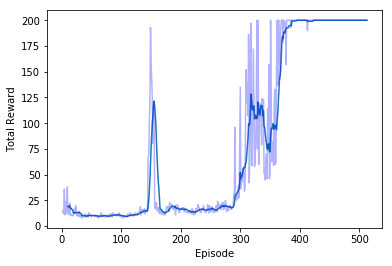

In [13]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(training_rewards).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='blue', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

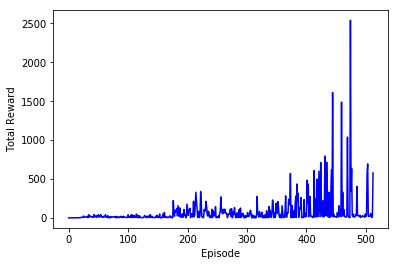

In [14]:
eps, loss = np.array(training_loss).T
plt.plot(loss, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()